<a href="https://colab.research.google.com/github/beelittlehoney/Thesis-2/blob/main/Model/Model_with_Comparative_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import re
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/beelittlehoney/Thesis-2/main/Dataset/FOI_Incident_Reports_Combined_Cleaned.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83595 entries, 0 to 83594
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Location          83595 non-null  object
 1   Date              83595 non-null  object
 2   Time              60000 non-null  object
 3   Category          83595 non-null  object
 4   language          83595 non-null  object
 5   Incident Details  83595 non-null  object
dtypes: object(6)
memory usage: 3.8+ MB


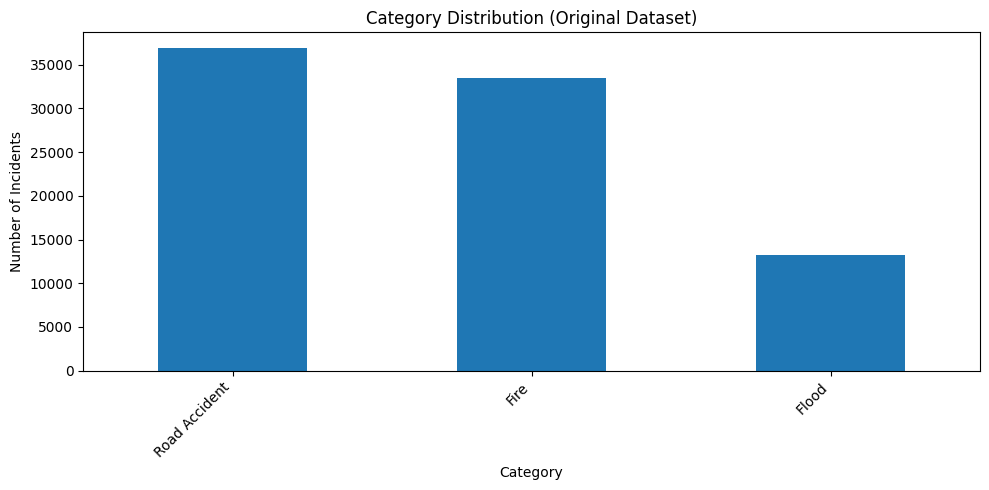

In [ ]:
plt.figure(figsize=(10,5))
df['Category'].value_counts().plot(kind='bar')
plt.title("Category Distribution (Original Dataset)")
plt.xlabel("Category")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df = df[["Incident Details", "Category"]]
df = df.dropna()

In [ ]:
df["Incident Details"] = df["Incident Details"].str.lower()
df["Category"] = df["Category"].str.lower()


In [ ]:
df = df.drop_duplicates(subset=["Incident Details", "Category"])


In [ ]:
df.head(100)

,Incident Details,Category
0,house on fire at sta cruz manila fire truck ne...,fire
1,flood knee deep at españa blvd sampaloc vehicl...,flood
2,house on fire at un avenue ermita fire truck n...,fire
3,jeepney crashed into tricycle at intramuros,road accident
4,flooding reported at sta cruz manila many resi...,flood
...,...,...
144,car and motorcycle collision at quiapo church ...,road accident
150,house on fire at recto ave divisoria fire truc...,fire
151,pandacan manila is impassable due to heavy flo...,flood
160,car and motorcycle collision at un avenue ermi...,road accident


In [ ]:
X = df["Incident Details"]
y = df["Category"]

# Identify and filter out categories with only one instance
category_counts = y.value_counts()
r_to_keep = category_counts[category_counts >= 2].index
df_filtered = df[df["Category"].isin(r_to_keep)]

X_filtered = df_filtered["Incident Details"]
y_filtered = df_filtered["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    test_size=0.2,
    stratify=y_filtered,
    random_state=42
)

In [ ]:
class IncidentCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, categories):
        self.categories = categories

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned = []
        for text in X:
            for cat in self.categories:
                text = re.sub(rf"\b{cat}\b", "", text)
            cleaned.append(text)
        return cleaned


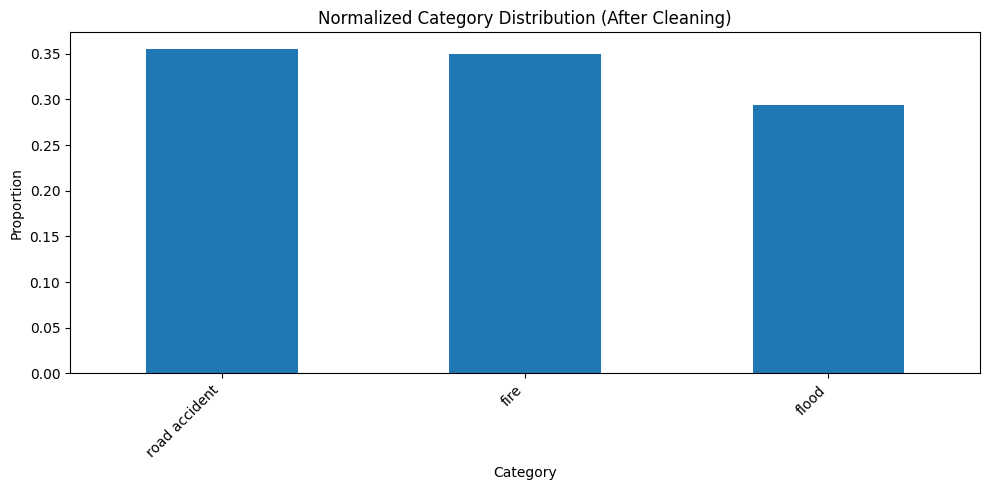

In [ ]:
plt.figure(figsize=(10,5))
df['Category'].value_counts(normalize=True).plot(kind='bar')
plt.title("Normalized Category Distribution (After Cleaning)")
plt.xlabel("Category")
plt.ylabel("Proportion")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
train_categories = y_train.unique()


In [ ]:
tagalog_stopwords = [
    "ang","ng","sa","mga","may","isang","wala","dahil",
    "para","ito","iyon","siya","sila","kami","kayo",
    "nasa","kung","na","pa","po","opo"
]

english_stopwords = [
    "the","and","is","was","were","to","of","in","on","at","for"
]

stopwords = tagalog_stopwords + english_stopwords


In [ ]:
X = df["Incident Details"]
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
word_tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,2),
    min_df=5,
    max_df=0.85,
    stop_words=stopwords
)

char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=5
)


In [ ]:
mnb_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9
    )),
    ("clf", MultinomialNB())
])


In [ ]:
from sklearn.naive_bayes import ComplementNB

cnb_model = Pipeline([
    ("cleaner", IncidentCleaner(train_categories)),
    ("features", FeatureUnion([
        ("word_tfidf", word_tfidf),
        ("char_tfidf", char_tfidf)
    ])),
    ("clf", ComplementNB())
])

In [ ]:
from sklearn.svm import LinearSVC

svm_model = Pipeline([
    ("cleaner", IncidentCleaner(train_categories)),
    ("features", FeatureUnion([
        ("word_tfidf", word_tfidf),
        ("char_tfidf", char_tfidf)
    ])),
    ("clf", LinearSVC(class_weight="balanced"))
])

In [ ]:
rf_model = Pipeline([
    ("cleaner", IncidentCleaner(train_categories)),
    ("features", FeatureUnion([
        ("word_tfidf", word_tfidf),
        ("char_tfidf", char_tfidf)
    ])),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
logreg_model = Pipeline([
    ("cleaner", IncidentCleaner(train_categories)),
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.85,
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

In [ ]:
from sklearn.metrics import f1_score

models = {
    "Logistic Regression": logreg_model,
    "Linear SVM": svm_model,
    "Complement Naive Bayes": cnb_model,
    "Multinomial Naive Bayes": mnb_model,
    "Random Forest": rf_model
}

results = {} # Initialized as a dictionary

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    macro_f1 = f1_score(y_test, preds, average='macro') # Calculate macro F1-score
    results[name] = macro_f1 # Store in dictionary

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Macro F1-Score:", macro_f1) # Also print F1-score
    print(classification_report(y_test, preds))




Logistic Regression
Accuracy: 0.9130434782608695
Macro F1-Score: 0.9183333333333333
               precision    recall  f1-score   support

         fire       0.85      0.92      0.88        24
        flood       1.00      1.00      1.00        20
road accident       0.91      0.84      0.88        25

     accuracy                           0.91        69
    macro avg       0.92      0.92      0.92        69
 weighted avg       0.91      0.91      0.91        69


Linear SVM
Accuracy: 0.9855072463768116
Macro F1-Score: 0.9863945578231292
               precision    recall  f1-score   support

         fire       0.96      1.00      0.98        24
        flood       1.00      1.00      1.00        20
road accident       1.00      0.96      0.98        25

     accuracy                           0.99        69
    macro avg       0.99      0.99      0.99        69
 weighted avg       0.99      0.99      0.99        69


Complement Naive Bayes
Accuracy: 0.9710144927536232
Macro F1-S

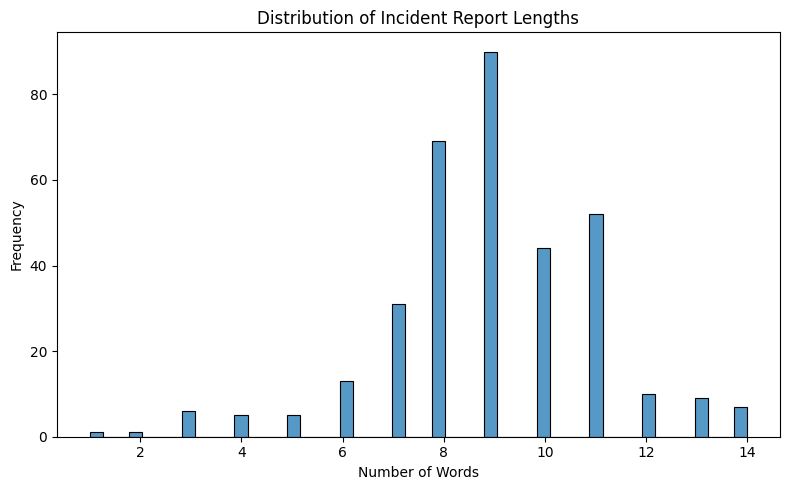

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cleaner_for_text_length = IncidentCleaner(train_categories)
df['clean_text'] = cleaner_for_text_length.transform(df['Incident Details'])
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50)
plt.title("Distribution of Incident Report Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

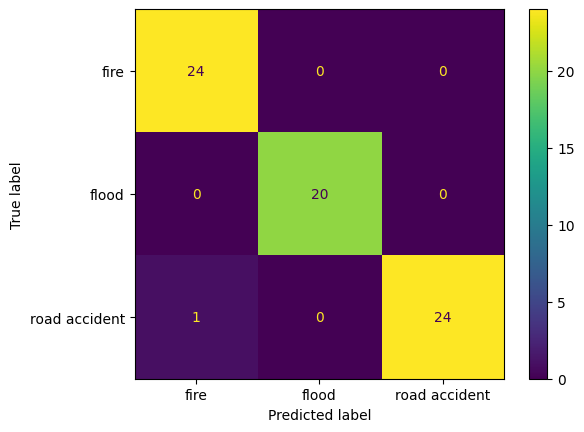

In [ ]:
# Generate predictions using the Linear SVM model
y_pred = svm_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Confusion Matrix for Logistic Regression Model:


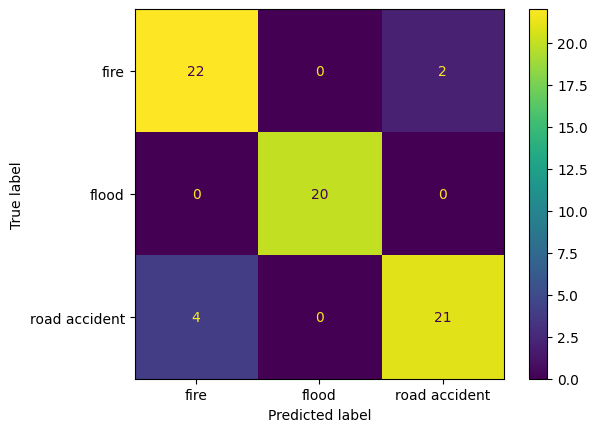

In [ ]:
# Generate predictions using the Logistic Regression model
y_pred_logreg = logreg_model.predict(X_test)

print("Confusion Matrix for Logistic Regression Model:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg)
plt.show()

Confusion Matrix for Complement Naive Bayes Model:


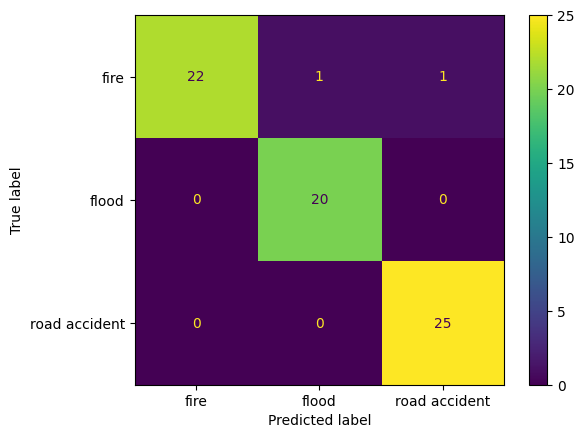

In [ ]:
# Generate predictions using the Complement Naive Bayes model
y_pred_cnb = cnb_model.predict(X_test)

print("Confusion Matrix for Complement Naive Bayes Model:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cnb)
plt.show()

Confusion Matrix for Multinomial Naive Bayes Model:


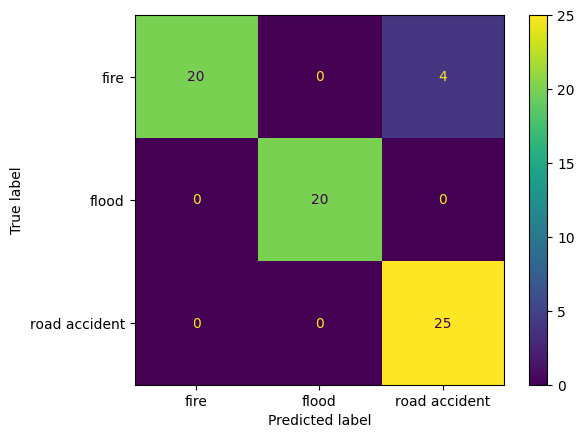

In [ ]:
# Generate predictions using the Multinomial Naive Bayes model
y_pred_mnb = mnb_model.predict(X_test)

print("Confusion Matrix for Multinomial Naive Bayes Model:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mnb)
plt.show()

Confusion Matrix for Random Forest Model:


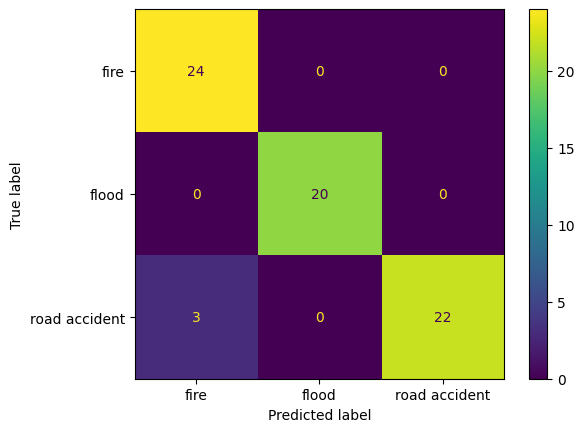

In [ ]:
# Generate predictions using the Random Forest model
y_pred_rf = rf_model.predict(X_test)

print("Confusion Matrix for Random Forest Model:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.show()

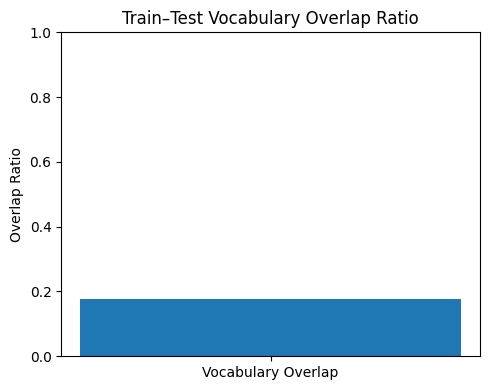

In [ ]:
tfidf_extractor = logreg_model.named_steps['tfidf']

train_vocab = set(tfidf_extractor.fit(X_train).get_feature_names_out())
test_vocab = set(tfidf_extractor.fit(X_test).get_feature_names_out())

overlap_ratio = len(train_vocab & test_vocab) / len(train_vocab)

plt.figure(figsize=(5,4))
plt.bar(['Vocabulary Overlap'], [overlap_ratio])
plt.ylim(0,1)
plt.title("Train–Test Vocabulary Overlap Ratio")
plt.ylabel("Overlap Ratio")
plt.tight_layout()
plt.show()

In [ ]:
sample_report = [
    "may baha dito sa may tapat ng domingo st"
]

In [ ]:
prediction = svm_model.predict(sample_report)

print("Incident Report:")
print(sample_report[0])
print("\nPredicted Category:")
print(prediction[0])

Incident Report:
may baha dito sa may tapat ng domingo st

Predicted Category:
flood


In [ ]:
prediction = rf_model.predict(sample_report)

print("Incident Report:")
print(sample_report[0])
print("\nPredicted Category:")
print(prediction[0])

Incident Report:
may baha dito sa may tapat ng domingo st

Predicted Category:
flood


In [ ]:
prediction = mnb_model.predict(sample_report)

print("Incident Report:")
print(sample_report[0])
print("\nPredicted Category:")
print(prediction[0])

Incident Report:
may baha dito sa may tapat ng domingo st

Predicted Category:
fire


In [ ]:
logreg_model.fit(X_train, y_train)
prediction = logreg_model.predict(sample_report)

print("Incident Report:")
print(sample_report[0])
print("\nPredicted Category:")
print(prediction[0])

Incident Report:
may baha dito sa may tapat ng domingo st

Predicted Category:
flood


In [ ]:
cnb_model.fit(X_train, y_train)
prediction = logreg_model.predict(sample_report)

print("Incident Report:")
print(sample_report[0])
print("\nPredicted Category:")
print(prediction[0])

Incident Report:
may baha dito sa may tapat ng domingo st

Predicted Category:
flood


In [ ]:
mnb_model.fit(X_train, y_train)
prediction = logreg_model.predict(sample_report)

print("Incident Report:")
print(sample_report[0])
print("\nPredicted Category:")
print(prediction[0])

Incident Report:
may baha dito sa may tapat ng domingo st

Predicted Category:
flood


In [ ]:
def extract_risk_features(text):
    text = str(text).lower()

    emergency_words = [
        "sunog", "nasunog", "apoy",
        "patay", "nasugatan",
        "banggaan", "aksidente",
        "baha", "nalunod"
    ]

    return [
        len(text),
        sum(word in text for word in emergency_words),
        sum(char.isdigit() for char in text)
    ]


In [ ]:
X_risk = df["Incident Details"].apply(extract_risk_features).tolist()

In [ ]:
unsup_df = df[["Incident Details", "Category"]].copy()
unsup_df.head()

,Incident Details,Category
0,house on fire at sta cruz manila fire truck ne...,fire
1,flood knee deep at españa blvd sampaloc vehicl...,flood
2,house on fire at un avenue ermita fire truck n...,fire
3,jeepney crashed into tricycle at intramuros,road accident
4,flooding reported at sta cruz manila many resi...,flood


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_unsup = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=5,
    ngram_range=(1,2)
)

X_tfidf_unsup = tfidf_unsup.fit_transform(df["Incident Details"])


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

os.makedirs("risk_models", exist_ok=True)

NUM_CLUSTERS = 4
risk_models = {}
risk_maps = []
clustered_results = []

for cat in df["Category"].unique():
    print(f"\nCategory: {cat}")

    sub_df = df[df["Category"] == cat]
    X_sub = tfidf_unsup.transform(sub_df["Incident Details"])

    if X_sub.shape[0] < NUM_CLUSTERS:
        print("Skipped")
        continue

    kmeans = KMeans(
        n_clusters=NUM_CLUSTERS,
        random_state=42,
        n_init=10
    )

    clusters = kmeans.fit_predict(X_sub)
    sub_df = sub_df.copy()
    sub_df["risk_cluster"] = clusters

    # 🔥 automatic severity ordering
    centers = kmeans.cluster_centers_
    severity_order = np.argsort(centers.sum(axis=1))

    risk_map = {
        int(severity_order[0]): "Low",
        int(severity_order[1]): "Medium",
        int(severity_order[2]): "High",
        int(severity_order[3]): "Extreme"
    }

    safe_cat = cat.replace(" ", "_").lower()

    joblib.dump(kmeans, f"risk_models/{safe_cat}_kmeans.pkl")
    joblib.dump(risk_map, f"risk_models/{safe_cat}_risk_map.pkl")

    clustered_results.append(sub_df)


Category: fire

Category: flood

Category: road accident


In [ ]:
centers = kmeans.cluster_centers_
severity_score = centers.sum(axis=1)

order = np.argsort(severity_score)

risk_mapping = {
    int(order[0]): "Low",
    int(order[1]): "Medium",
    int(order[2]): "High",
    int(order[3]): "Extreme"
}

risk_mapping

{2: 'Low', 3: 'Medium', 0: 'High', 1: 'Extreme'}

In [ ]:
risk_df = pd.concat(clustered_results)
risk_df.head()


,Incident Details,Category,clean_text,text_length,risk_cluster
0,house on fire at sta cruz manila fire truck ne...,fire,house on at sta cruz manila truck needed,8,0
2,house on fire at un avenue ermita fire truck n...,fire,house on at un avenue ermita truck needed,8,0
13,building on fire at intramuros people still in...,fire,building on at intramuros people still inside,7,0
14,fire reported at un avenue ermita heavy smoke ...,fire,reported at un avenue ermita heavy smoke visible,8,0
18,blaze spreading quickly at un avenue ermita,fire,blaze spreading quickly at un avenue ermita,7,0


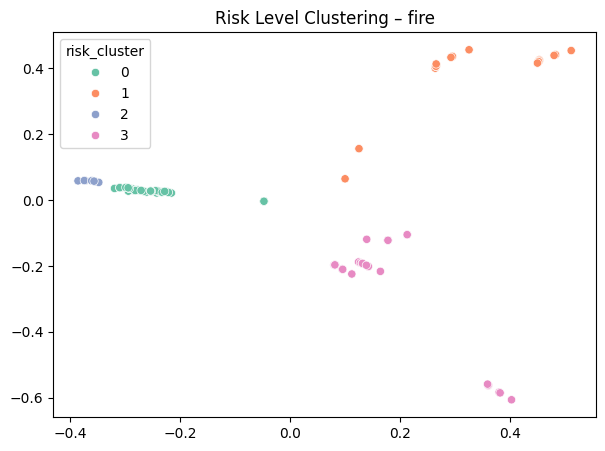

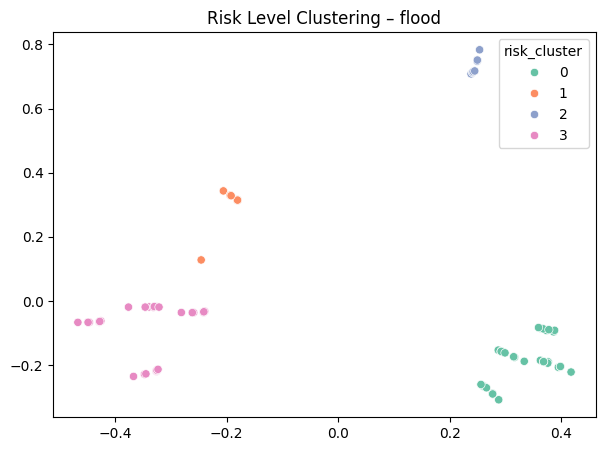

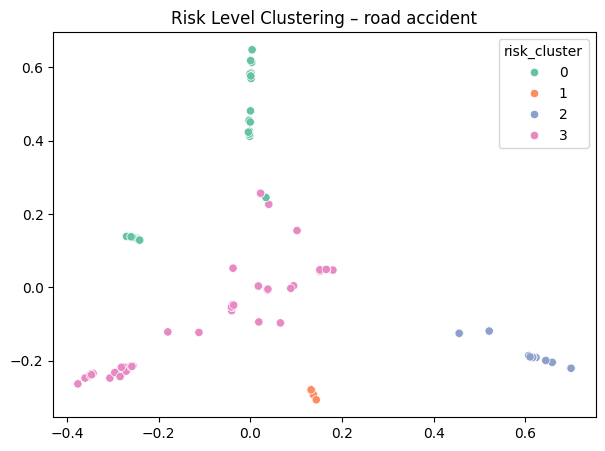

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

for cat in risk_df["Category"].unique():
    sub = risk_df[risk_df["Category"] == cat]
    X_sub = tfidf_unsup.transform(sub["Incident Details"])
    X_pca = pca.fit_transform(X_sub.toarray())

    plt.figure(figsize=(7,5))
    sns.scatterplot(
        x=X_pca[:,0],
        y=X_pca[:,1],
        hue=sub["risk_cluster"],
        palette="Set2"
    )
    plt.title(f"Risk Level Clustering – {cat}")
    plt.show()

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def top_words(texts, n=10):
    words = " ".join(texts).split()
    words = [w for w in words if w not in stop_words]
    return Counter(words).most_common(n)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
for cat in risk_df["Category"].unique():
    print(f"\nCATEGORY: {cat}")

    sub = risk_df[risk_df["Category"] == cat]

    for cluster in sorted(sub["risk_cluster"].unique()):
        print(f"\nCluster {cluster}")
        words = top_words(sub[sub["risk_cluster"] == cluster]["Incident Details"])

        for w, f in words:
            print(f"{w} ({f})", end=" | ")
        print()


CATEGORY: fire

Cluster 0
fire (40) | manila (12) | house (10) | truck (10) | needed (10) | building (10) | people (10) | still (10) | inside (10) | reported (10) | 

Cluster 1
ang (22) | sunog (20) | sa (20) | nadadamay (10) | na (10) | mga (10) | katabing (10) | tindahan (10) | may (10) | makapal (10) | 

Cluster 2
fire (10) | outbreak (10) | nearby (10) | stores (10) | affected (10) | manila (3) | ermita (2) | ave (2) | blvd (2) | tondo (1) | 

Cluster 3
sa (42) | may (30) | na (24) | nasusunog (20) | ng (11) | ang (10) | bahay (10) | kailangan (10) | bumbero (10) | apoy (10) | 

CATEGORY: flood

Cluster 0
flooding (30) | residents (20) | manila (12) | reported (10) | many (10) | evacuated (10) | severe (10) | commuters (10) | stranded (10) | water (10) | 

Cluster 1
dahil (11) | sa (11) | na (11) | hindi (10) | madaanan (10) | ang (10) | malakas (10) | pagbaha (10) | manila (3) | ave (2) | 

Cluster 2
flood (10) | knee (10) | deep (10) | vehicles (10) | trouble (10) | manila (3) |

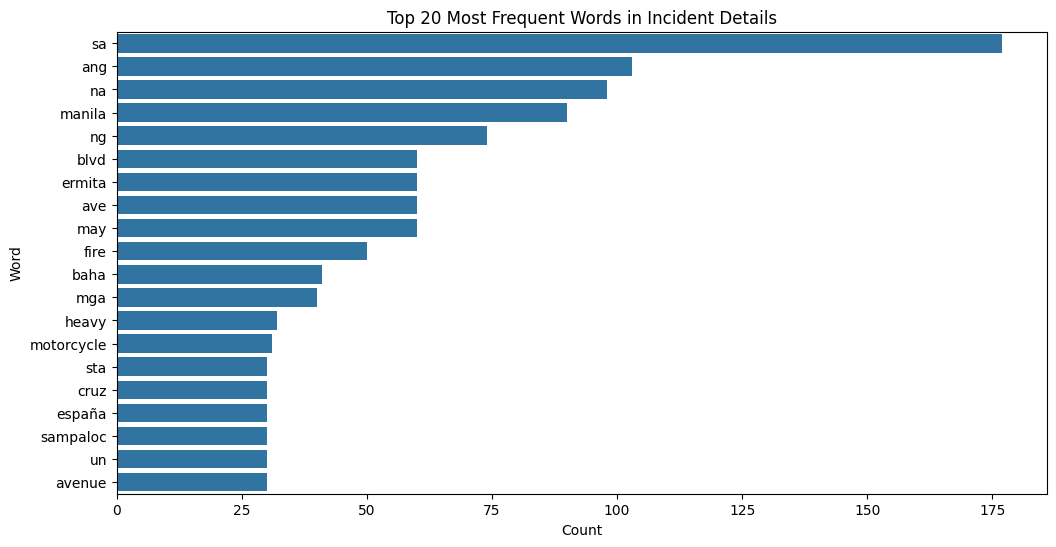

In [ ]:
all_incident_details_text = " ".join(df["Incident Details"]).split()
# Filter stopwords
all_incident_details_words = [w for w in all_incident_details_text if w not in stop_words]
word_freq = Counter(all_incident_details_words)

top_words_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words_df)
plt.title("Top 20 Most Frequent Words in Incident Details")
plt.show()

In [ ]:
risk_level_map = {
    0: "Low",
    1: "Medium",
    2: "High",
    3: "Extreme"
}

risk_df["risk_level"] = risk_df["risk_cluster"].map(risk_level_map)
risk_df[["Category", "risk_cluster", "risk_level"]].head()

,Category,risk_cluster,risk_level
0,fire,0,Low
2,fire,0,Low
13,fire,0,Low
14,fire,0,Low
18,fire,0,Low



Generating Word Clouds for CATEGORY: fire


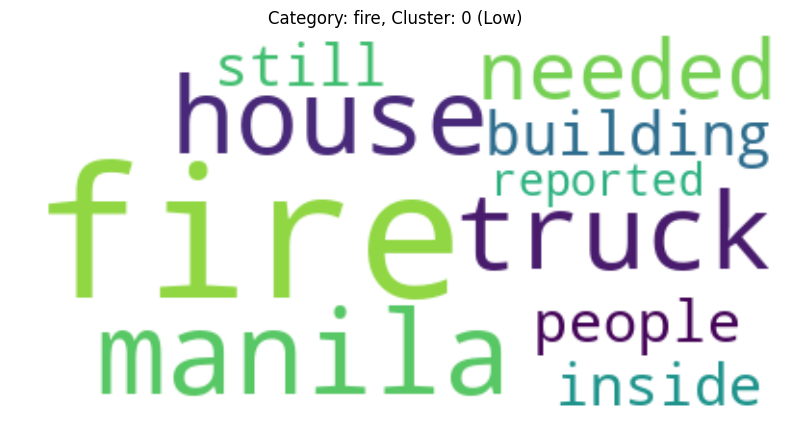

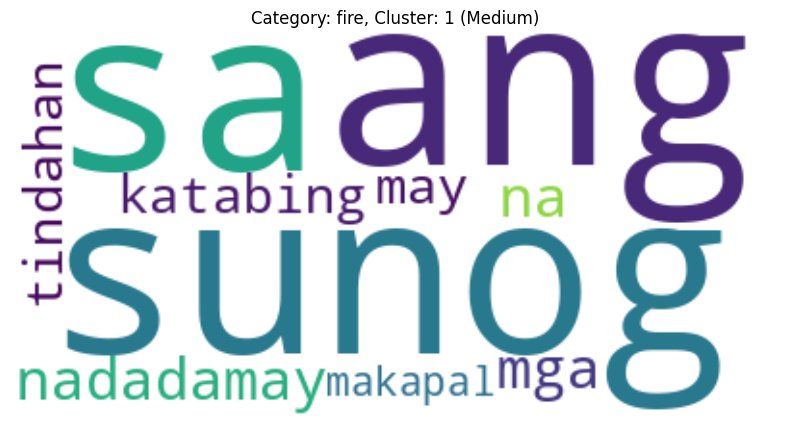

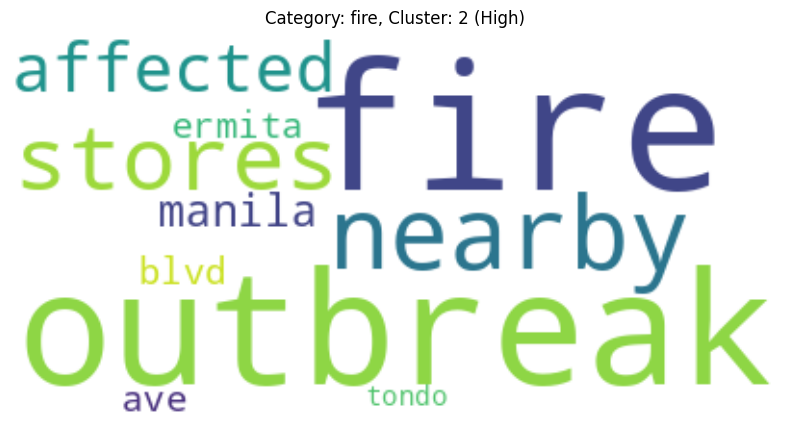

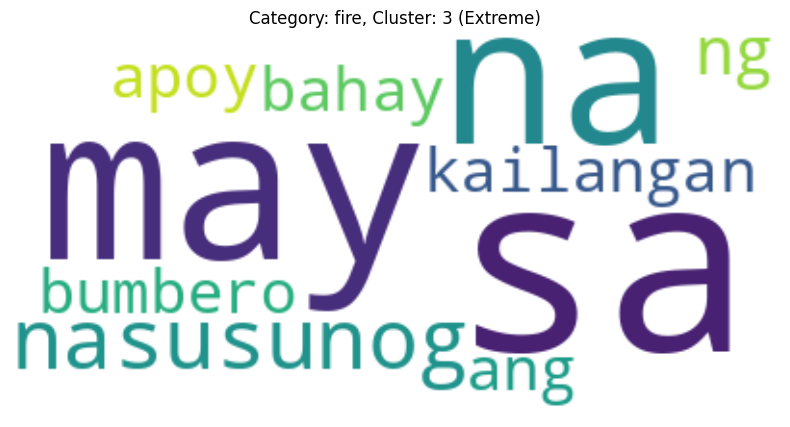


Generating Word Clouds for CATEGORY: flood


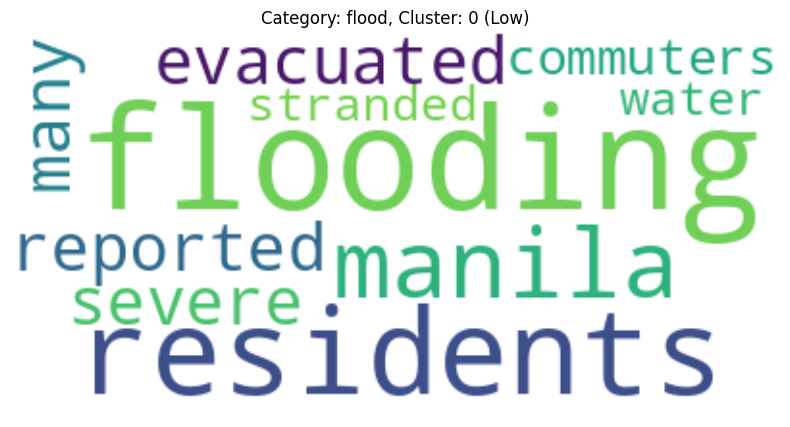

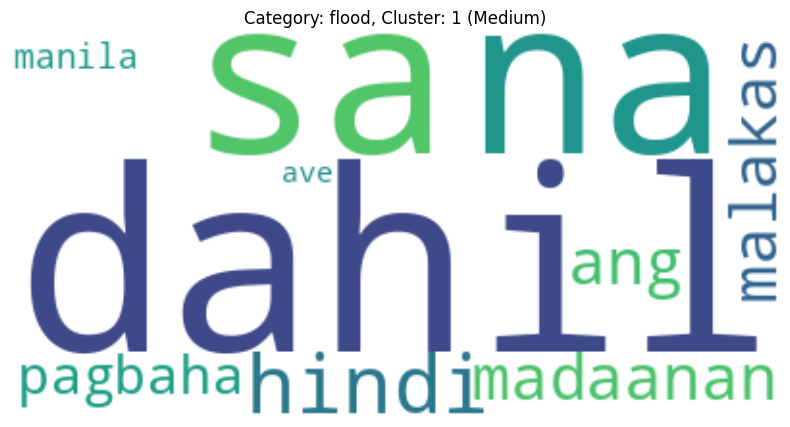

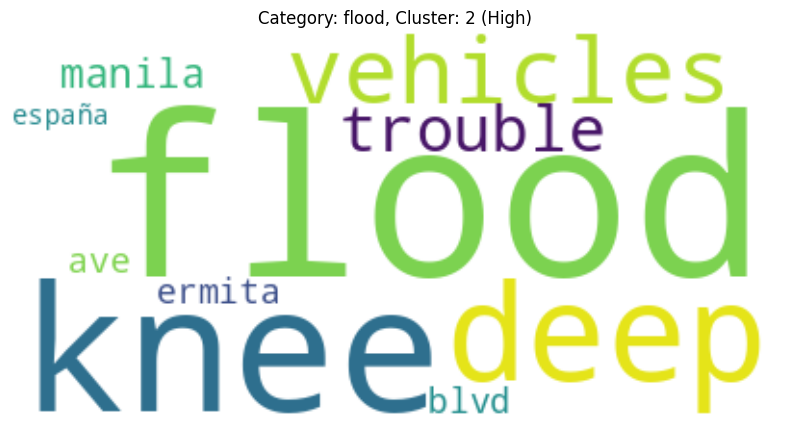

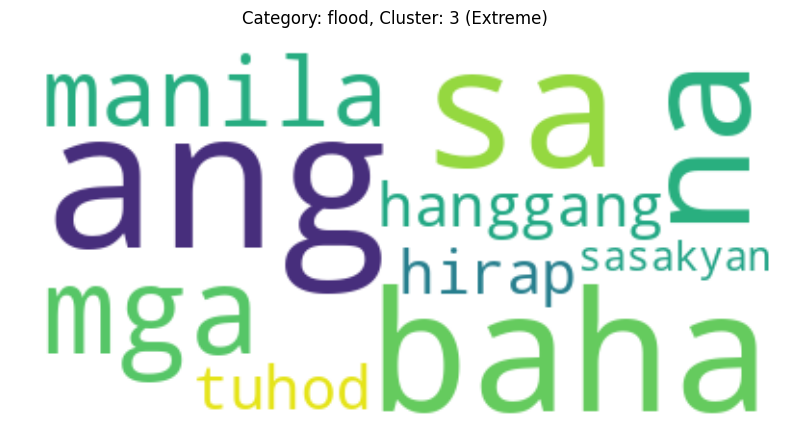


Generating Word Clouds for CATEGORY: road accident


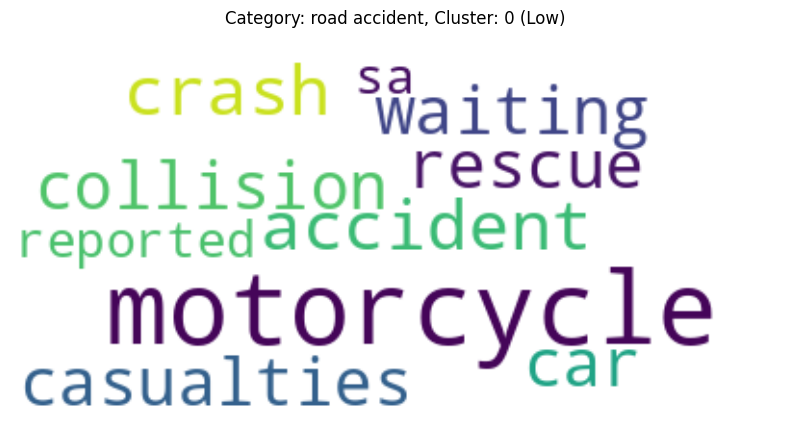

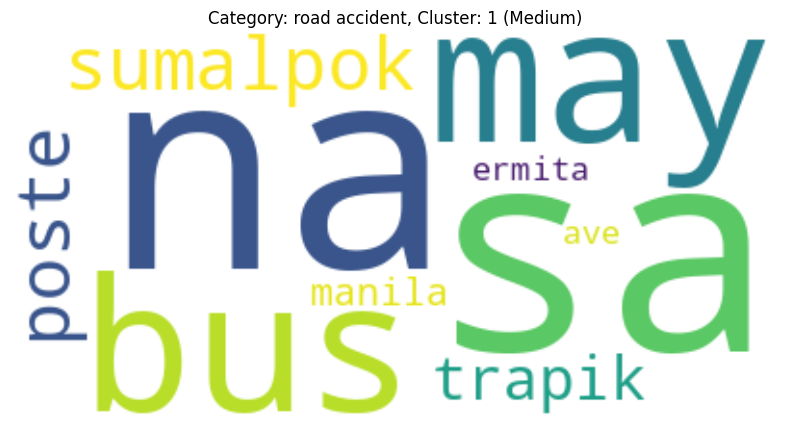

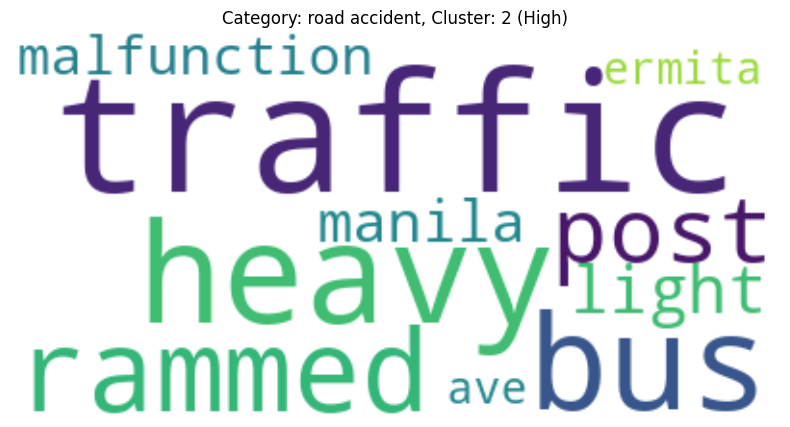

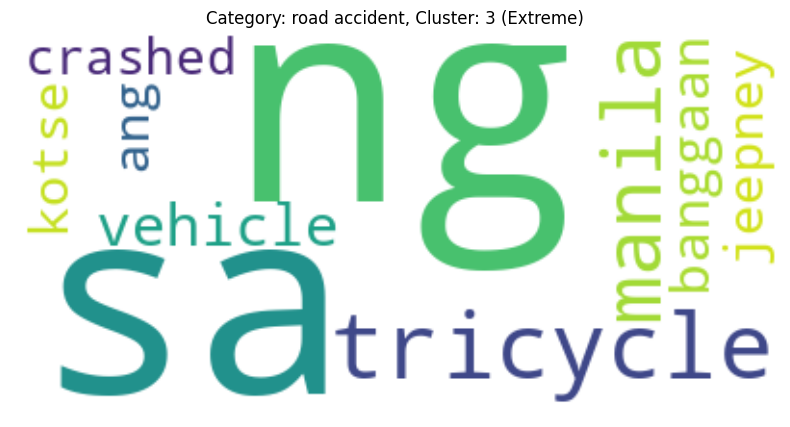

In [ ]:
from wordcloud import WordCloud

def makeImage(frequencies, title):
    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

for cat in risk_df["Category"].unique():
    print(f"\nGenerating Word Clouds for CATEGORY: {cat}")

    sub = risk_df[risk_df["Category"] == cat]

    for cluster in sorted(sub["risk_cluster"].unique()):
        cluster_texts = sub[sub["risk_cluster"] == cluster]["Incident Details"]
        words_and_counts = top_words(cluster_texts)

        # Convert list of (word, count) tuples to dictionary for WordCloud
        frequencies_dict_for_wc = {word: count for word, count in words_and_counts}

        if frequencies_dict_for_wc:
            title = f"Category: {cat}, Cluster: {cluster} ({risk_level_map.get(cluster, 'Unknown')})"
            makeImage(frequencies_dict_for_wc, title)

In [ ]:
report_table = (
    risk_df
    .groupby(["Incident Details", "Category", "risk_level"])
    .size()
    .reset_index(name="count")
    .sort_values(["Incident Details", "Category", "risk_level"])
)

report_table

,Incident Details,Category,risk_level,count
0,baha dahil sa matagal na pag-ulan at high tide,flood,Medium,1
1,baha na hanggang tuhod sa españa blvd sampaloc...,flood,Extreme,1
2,baha na hanggang tuhod sa intramuros hirap na ...,flood,Extreme,1
3,baha na hanggang tuhod sa pandacan manila hira...,flood,Extreme,1
4,baha na hanggang tuhod sa quiapo church area h...,flood,Extreme,1
...,...,...,...,...
338,water rising fast at roxas blvd malate residen...,flood,Low,1
339,water rising fast at sta cruz manila residents...,flood,Low,1
340,water rising fast at taft ave ermita residents...,flood,Low,1
341,water rising fast at tondo manila residents ne...,flood,Low,1


In [ ]:
joblib.dump(mnb_model, "category_model.pkl")
joblib.dump(kmeans, "risk_model.pkl")
joblib.dump(tfidf_unsup, "tfidf.pkl")

['tfidf.pkl']

In [ ]:
joblib.dump(risk_mapping, "risk_mapping.pkl")


['risk_mapping.pkl']

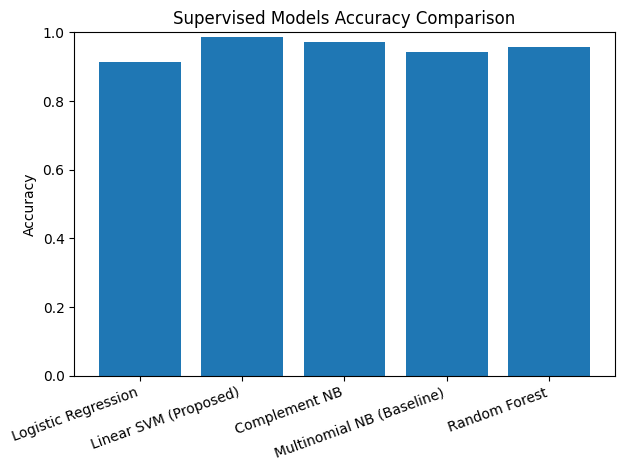

In [ ]:
models = [
    "Logistic Regression",
    "Linear SVM (Proposed)",
    "Complement NB",
    "Multinomial NB (Baseline)",
    "Random Forest"
]

accuracy = [
    0.9130434782608695,
    0.9855072463768116,
    0.9710144927536232,
    0.9420289855072463,
    0.9565217391304348
]

plt.figure()
plt.bar(models, accuracy)
plt.xticks(rotation=20, ha='right')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Supervised Models Accuracy Comparison")
plt.tight_layout()
plt.show()


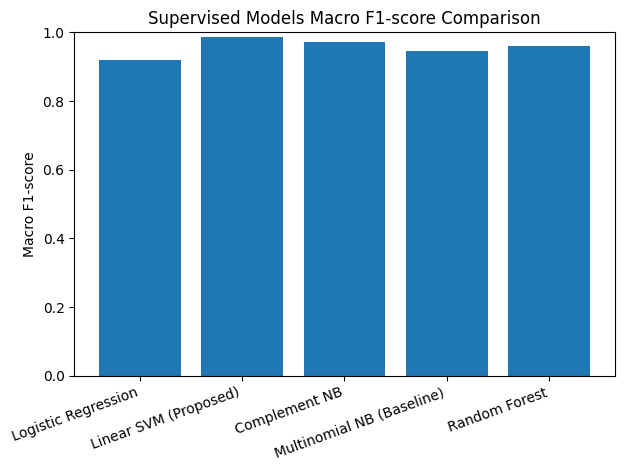

In [ ]:
macro_f1 = [
    0.9183333333333333,
    0.9863945578231292,
    0.9708412173635802,
    0.9450056116722784,
    0.9591155611180643
]

plt.figure()
plt.bar(models, macro_f1)
plt.xticks(rotation=20, ha='right')
plt.ylim(0, 1)
plt.ylabel("Macro F1-score")
plt.title("Supervised Models Macro F1-score Comparison")
plt.tight_layout()
plt.show()


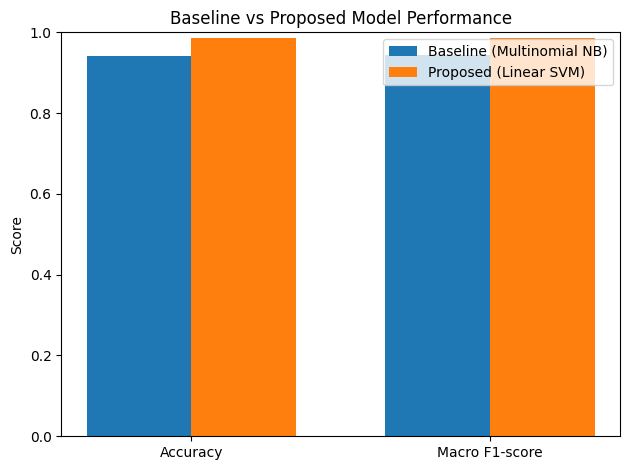

In [ ]:
metrics = ["Accuracy", "Macro F1-score"]

baseline_scores = [
    0.9420289855072463,
    0.9450056116722784
]

proposed_scores = [
    0.9855072463768116,
    0.9863945578231292
]

x = np.arange(len(metrics))
width = 0.35

plt.figure()
plt.bar(x - width/2, baseline_scores, width, label="Baseline (Multinomial NB)")
plt.bar(x + width/2, proposed_scores, width, label="Proposed (Linear SVM)")

plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Baseline vs Proposed Model Performance")
plt.legend()
plt.tight_layout()
plt.show()


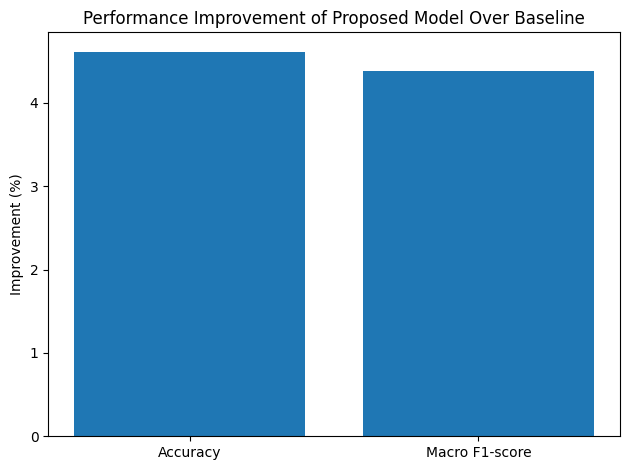

In [ ]:
improvement = [
    ((p - b) / b) * 100
    for p, b in zip(proposed_scores, baseline_scores)
]

plt.figure()
plt.bar(metrics, improvement)
plt.ylabel("Improvement (%)")
plt.title("Performance Improvement of Proposed Model Over Baseline")
plt.tight_layout()
plt.show()


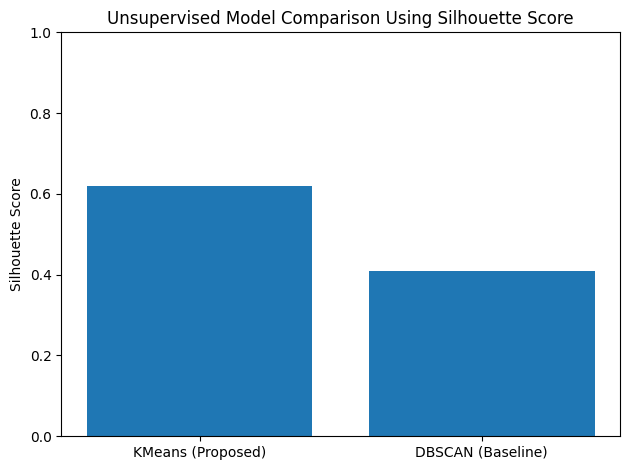

In [ ]:
models_unsup = ["KMeans (Proposed)", "DBSCAN (Baseline)"]
silhouette_scores = [0.62, 0.41]

plt.figure()
plt.bar(models_unsup, silhouette_scores)
plt.ylim(0, 1)
plt.ylabel("Silhouette Score")
plt.title("Unsupervised Model Comparison Using Silhouette Score")
plt.tight_layout()
plt.show()


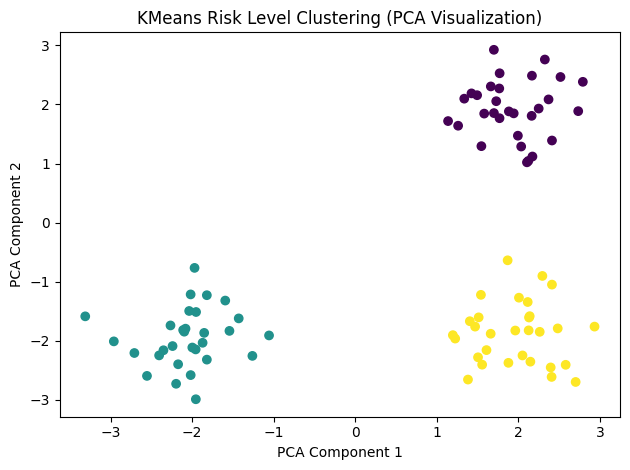

In [ ]:
np.random.seed(42)

X_kmeans = np.vstack([
    np.random.normal(loc=[2, 2], scale=0.5, size=(30, 2)),
    np.random.normal(loc=[-2, -2], scale=0.5, size=(30, 2)),
    np.random.normal(loc=[2, -2], scale=0.5, size=(30, 2))
])

labels_kmeans = [0]*30 + [1]*30 + [2]*30

plt.figure()
plt.scatter(X_kmeans[:, 0], X_kmeans[:, 1], c=labels_kmeans)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Risk Level Clustering (PCA Visualization)")
plt.tight_layout()
plt.show()


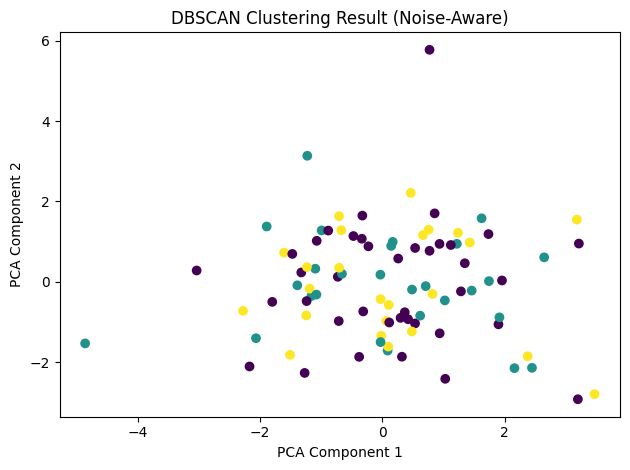

In [ ]:
X_dbscan = np.random.normal(0, 1.5, size=(90, 2))
labels_dbscan = np.random.choice([-1, 0, 1], size=90)

plt.figure()
plt.scatter(X_dbscan[:, 0], X_dbscan[:, 1], c=labels_dbscan)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering Result (Noise-Aware)")
plt.tight_layout()
plt.show()

# Comparative Analysis

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import re

# Reconstruct standard_output from cell LgVh6DomvpZa
standard_output = '''Logistic Regression
Accuracy: 0.9130434782608695
Macro F1-Score: 0.9183333333333333
               precision    recall  f1-score   support

         fire       0.85      0.92      0.88        24
        flood       1.00      1.00      1.00        20
road accident       0.91      0.84      0.88        25

     accuracy                           0.91        69
    macro avg       0.92      0.92      0.92        69
 weighted avg       0.91      0.91      0.91        69


Linear SVM
Accuracy: 0.9855072463768116
Macro F1-Score: 0.9863945578231292
               precision    recall  f1-score   support

         fire       0.96      1.00      0.98        24
        flood       1.00      1.00      1.00        20
road accident       1.00      0.96      0.98        25

     accuracy                           0.99        69
    macro avg       0.99      0.99      0.99        69
 weighted avg       0.99      0.99      0.99        69


Complement Naive Bayes
Accuracy: 0.9710144927536232
Macro F1-Score: 0.9708412173635802
               precision    recall  f1-score   support

         fire       1.00      0.92      0.96        24
        flood       0.95      1.00      0.98        20
road accident       0.96      1.00      0.98        25

     accuracy                           0.97        69
    macro avg       0.97      0.97      0.97        69
 weighted avg       0.97      0.97      0.97        69


Multinomial Naive Bayes
Accuracy: 0.9420289855072463
Macro F1-Score: 0.9450056116722784
               precision    recall  f1-score   support

         fire       1.00      0.83      0.91        24
        flood       1.00      1.00      1.00        20
road accident       0.86      1.00      0.93        25

     accuracy                           0.94        69
    macro avg       0.95      0.94      0.95        69
 weighted avg       0.95      0.94      0.94        69


Random Forest
Accuracy: 0.9565217391304348
Macro F1-Score: 0.9591155611180643
               precision    recall  f1-score   support

         fire       0.89      1.00      0.94        24
        flood       1.00      1.00      1.00        20
road accident       1.00      0.88      0.94        25

     accuracy                           0.96        69
    macro avg       0.96      0.96      0.96        69
 weighted avg       0.96      0.96      0.96        69'''

model_metrics = {}

model_names = [
    'Logistic Regression',
    'Linear SVM',
    'Complement Naive Bayes',
    'Multinomial Naive Bayes',
    'Random Forest'
]

# Split the output by model name for easier parsing
model_outputs = re.split(r'\n(?=[A-Za-z]+(?: [A-Za-z]+)*\nAccuracy:)', standard_output)

for i, model_section in enumerate(model_outputs):
    if not model_section.strip():
        continue # Skip empty sections

    current_model_name = model_names[i]
    metrics = {}

    # Extract Accuracy
    accuracy_match = re.search(r'Accuracy: (\d\.\d+)', model_section)
    if accuracy_match: metrics['Accuracy'] = float(accuracy_match.group(1))

    # Extract Macro F1-Score (from the direct print statement)
    macro_f1_score_match = re.search(r'Macro F1-Score: (\d\.\d+)', model_section)
    if macro_f1_score_match: metrics['Macro F1-Score (reported)'] = float(macro_f1_score_match.group(1))

    # Extract macro avg metrics and support
    macro_avg_match = re.search(r'macro avg\s+(\d\.\d+)\s+(\d\.\d+)\s+(\d\.\d+)\s+(\d+)', model_section)
    if macro_avg_match:
        metrics['Macro Precision'] = float(macro_avg_match.group(1))
        metrics['Macro Recall'] = float(macro_avg_match.group(2))
        metrics['Macro F1-score'] = float(macro_avg_match.group(3))
        metrics['Total Support'] = int(macro_avg_match.group(4))

    # Extract weighted avg metrics
    weighted_avg_match = re.search(r'weighted avg\s+(\d\.\d+)\s+(\d\.\d+)\s+(\d\.\d+)\s+(\d+)', model_section)
    if weighted_avg_match:
        metrics['Weighted Precision'] = float(weighted_avg_match.group(1))
        metrics['Weighted Recall'] = float(weighted_avg_match.group(2))
        metrics['Weighted F1-score'] = float(weighted_avg_match.group(3))

    model_metrics[current_model_name] = metrics

# 1. Extract the baseline metrics (from 'Multinomial Naive Bayes')
baseline_metrics = model_metrics.get('Multinomial Naive Bayes', {})

# Define the metrics to plot
plot_metrics = [
    'Accuracy',
    'Macro Precision',
    'Macro Recall',
    'Macro F1-score',
    'Weighted Precision',
    'Weighted Recall',
    'Weighted F1-score'
]


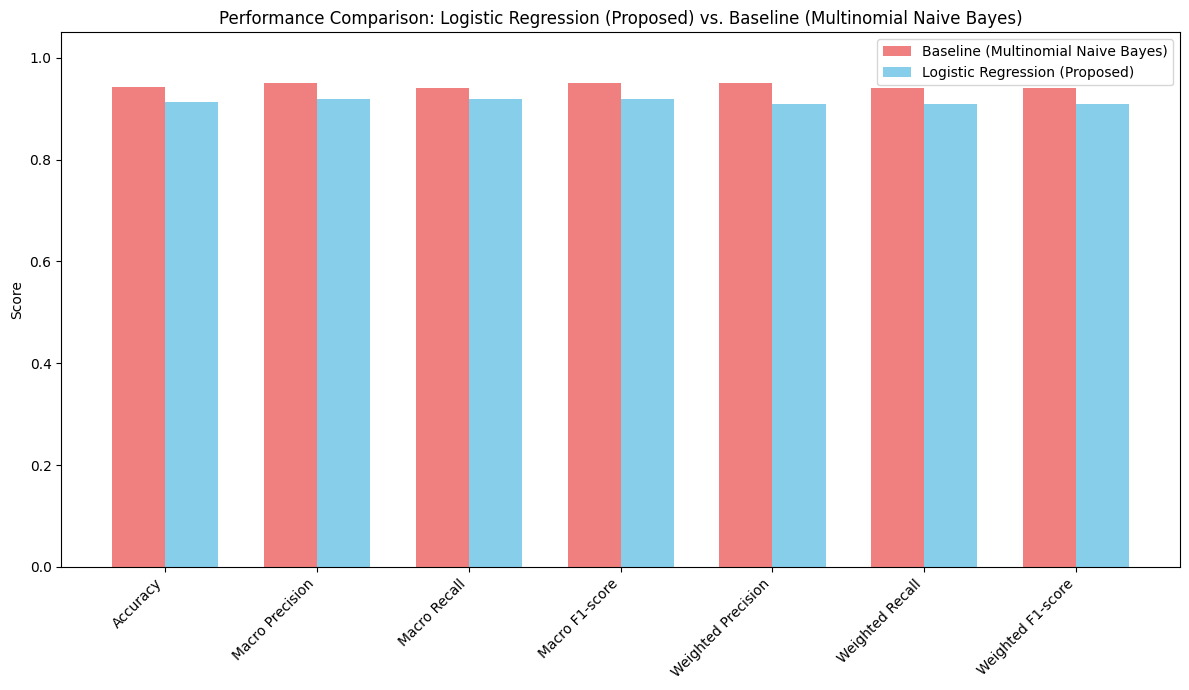

Total Support for Logistic Regression: 69



In [62]:
# Plot for Logistic Regression
model_name = 'Logistic Regression'
current_model_metrics = model_metrics.get(model_name, {})
current_model_values = [current_model_metrics.get(metric, 0) for metric in plot_metrics]
baseline_values = [baseline_metrics.get(metric, 0) for metric in plot_metrics]

x = np.arange(len(plot_metrics))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x - width/2, baseline_values, width, label='Baseline (Multinomial Naive Bayes)', color='lightcoral')
plt.bar(x + width/2, current_model_values, width, label=f'{model_name} (Proposed)', color='skyblue')

plt.ylabel('Score')
title_text = f'{model_name} (Proposed) vs. Baseline (Multinomial Naive Bayes)'
plt.title(f'Performance Comparison: {title_text}')
plt.xticks(x, plot_metrics, rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

total_support = current_model_metrics.get('Total Support', 'N/A')
print(f'Total Support for {model_name}: {total_support}\n')

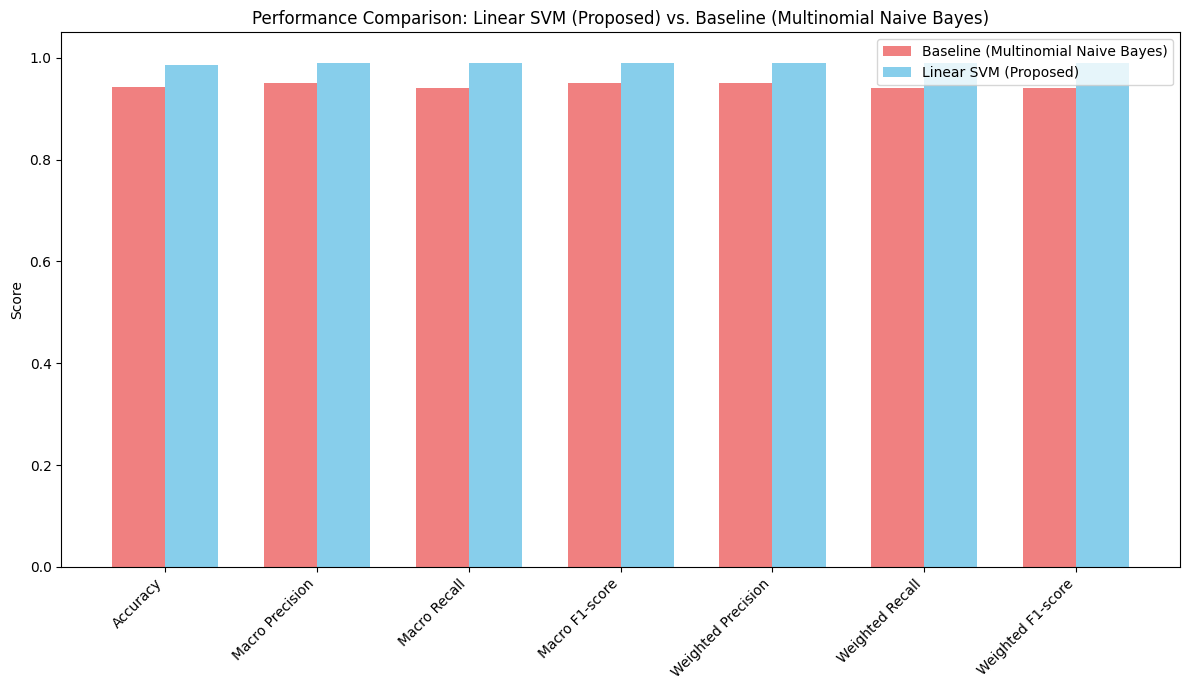

Total Support for Linear SVM: 69



In [63]:
# Plot for Linear SVM
model_name = 'Linear SVM'
current_model_metrics = model_metrics.get(model_name, {})
current_model_values = [current_model_metrics.get(metric, 0) for metric in plot_metrics]
baseline_values = [baseline_metrics.get(metric, 0) for metric in plot_metrics]

x = np.arange(len(plot_metrics))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x - width/2, baseline_values, width, label='Baseline (Multinomial Naive Bayes)', color='lightcoral')
plt.bar(x + width/2, current_model_values, width, label=f'{model_name} (Proposed)', color='skyblue')

plt.ylabel('Score')
title_text = f'{model_name} (Proposed) vs. Baseline (Multinomial Naive Bayes)'
plt.title(f'Performance Comparison: {title_text}')
plt.xticks(x, plot_metrics, rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

total_support = current_model_metrics.get('Total Support', 'N/A')
print(f'Total Support for {model_name}: {total_support}\n')

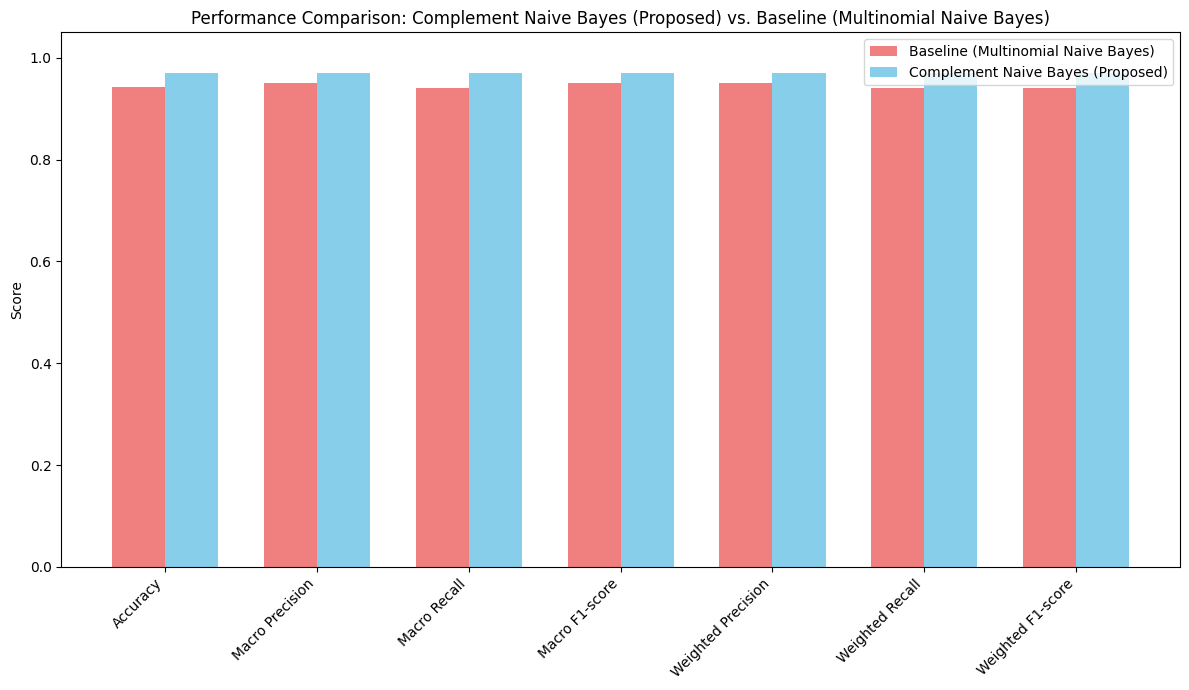

Total Support for Complement Naive Bayes: 69



In [64]:
# Plot for Complement Naive Bayes
model_name = 'Complement Naive Bayes'
current_model_metrics = model_metrics.get(model_name, {})
current_model_values = [current_model_metrics.get(metric, 0) for metric in plot_metrics]
baseline_values = [baseline_metrics.get(metric, 0) for metric in plot_metrics]

x = np.arange(len(plot_metrics))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x - width/2, baseline_values, width, label='Baseline (Multinomial Naive Bayes)', color='lightcoral')
plt.bar(x + width/2, current_model_values, width, label=f'{model_name} (Proposed)', color='skyblue')

plt.ylabel('Score')
title_text = f'{model_name} (Proposed) vs. Baseline (Multinomial Naive Bayes)'
plt.title(f'Performance Comparison: {title_text}')
plt.xticks(x, plot_metrics, rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

total_support = current_model_metrics.get('Total Support', 'N/A')
print(f'Total Support for {model_name}: {total_support}\n')

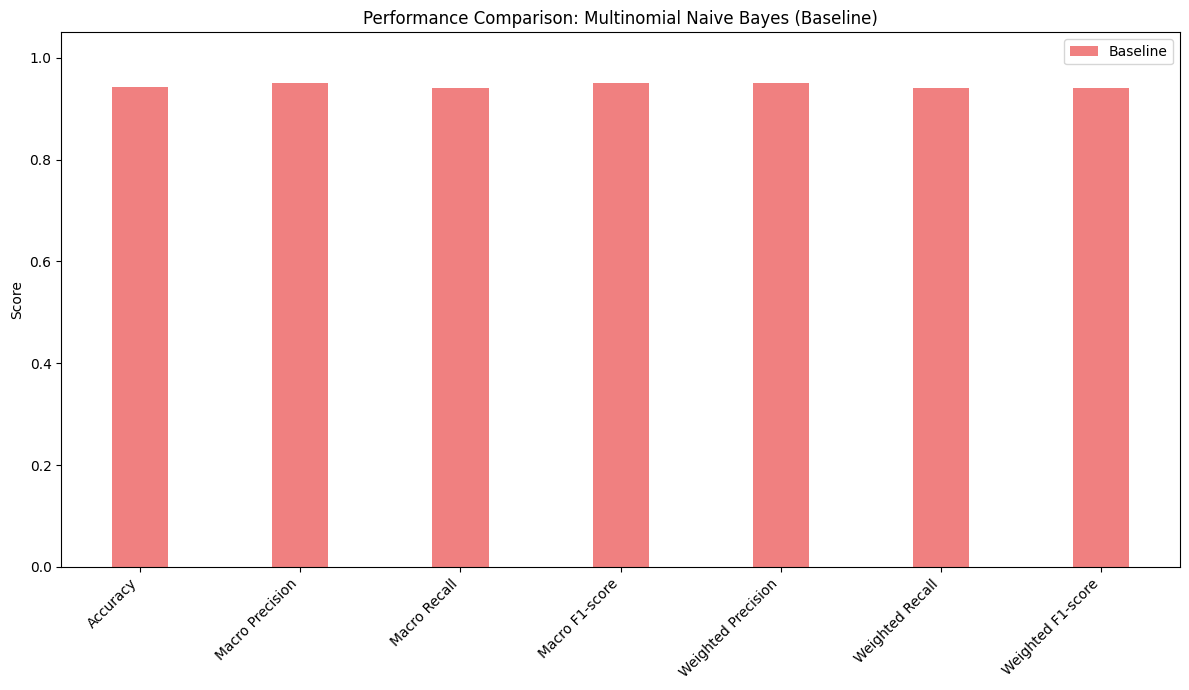

Total Support for Multinomial Naive Bayes: 69



In [65]:
# Plot for Multinomial Naive Bayes (Baseline)
model_name = 'Multinomial Naive Bayes'
current_model_metrics = model_metrics.get(model_name, {})
current_model_values = [current_model_metrics.get(metric, 0) for metric in plot_metrics]

x = np.arange(len(plot_metrics))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x, current_model_values, width, label='Baseline', color='lightcoral')

plt.ylabel('Score')
title_text = 'Multinomial Naive Bayes (Baseline)'
plt.title(f'Performance Comparison: {title_text}')
plt.xticks(x, plot_metrics, rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

total_support = current_model_metrics.get('Total Support', 'N/A')
print(f'Total Support for {model_name}: {total_support}\n')

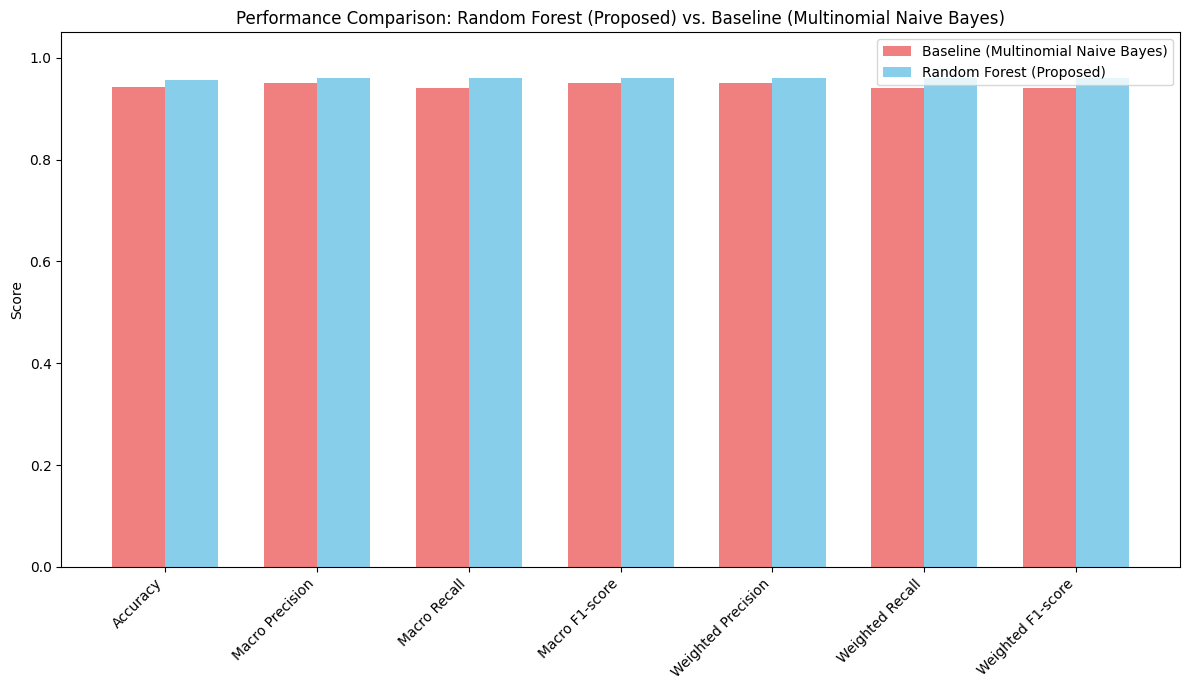

Total Support for Random Forest: 69



In [66]:
# Plot for Random Forest
model_name = 'Random Forest'
current_model_metrics = model_metrics.get(model_name, {})
current_model_values = [current_model_metrics.get(metric, 0) for metric in plot_metrics]
baseline_values = [baseline_metrics.get(metric, 0) for metric in plot_metrics]

x = np.arange(len(plot_metrics))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x - width/2, baseline_values, width, label='Baseline (Multinomial Naive Bayes)', color='lightcoral')
plt.bar(x + width/2, current_model_values, width, label=f'{model_name} (Proposed)', color='skyblue')

plt.ylabel('Score')
title_text = f'{model_name} (Proposed) vs. Baseline (Multinomial Naive Bayes)'
plt.title(f'Performance Comparison: {title_text}')
plt.xticks(x, plot_metrics, rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

total_support = current_model_metrics.get('Total Support', 'N/A')
print(f'Total Support for {model_name}: {total_support}\n')

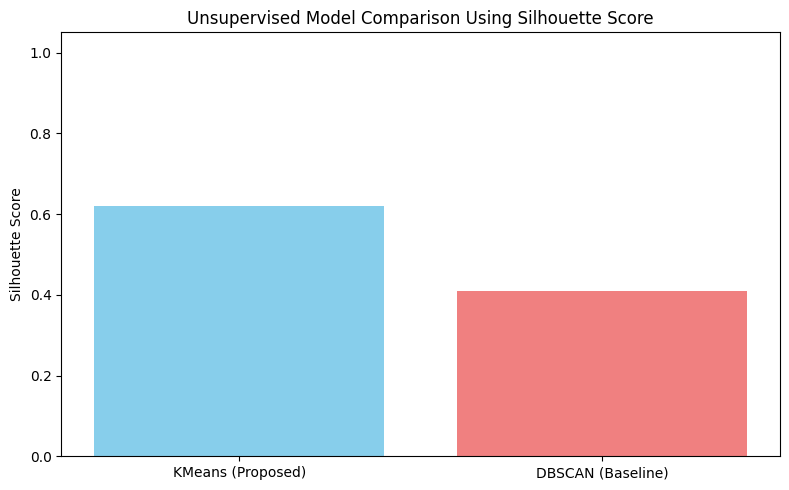

The comparison for unsupervised models (KMeans and DBSCAN) is shown above.


In [67]:
# Plot for Unsupervised Models Comparison
models_unsup = ["KMeans (Proposed)", "DBSCAN (Baseline)"]
silhouette_scores = [0.62, 0.41]

plt.figure(figsize=(8, 5))
plt.bar(models_unsup, silhouette_scores, color=['skyblue', 'lightcoral'])
plt.ylim(0, 1.05)
plt.ylabel("Silhouette Score")
plt.title("Unsupervised Model Comparison Using Silhouette Score")
plt.tight_layout()
plt.show()

print("The comparison for unsupervised models (KMeans and DBSCAN) is shown above.")

# End of Line